In [1]:
import os
import json
from collections import defaultdict

# Path to the directory you want to search
directory_path = './'

# This will hold the count of unique combinations
combinations = defaultdict(int)
combination_set = set()
# Loop through each folder, subfolder, and file
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Check if the file is a JSON file
        if file.endswith('.json'):
            json_path = os.path.join(root, file)
            # Open and read the JSON file
            with open(json_path, 'r') as json_file:
                data = json.load(json_file)
                # Extract the lesion and asymmetry values
                lesion_class = data.get("Lesion Class")
                asymmetry_label = data.get("Asymmetry Label")
                if lesion_class and asymmetry_label:
                    # Increment the count for this combination
                    combination_set.add((lesion_class, asymmetry_label))
                    combinations[(lesion_class, asymmetry_label)] += 1


# Now combinations dictionary has all unique combinations and their counts
total_combinations = len(combinations)
print(f'Total unique combinations of lesion and asymmetry: {total_combinations}')
print(combination_set)
# If you want to see the combinations,


Total unique combinations of lesion and asymmetry: 8
{('Atypical Nevus', 'Fully Symmetric'), ('Melanoma', 'Fully Symmetric'), ('Common Nevus', 'Symmetric in 1 axes'), ('Melanoma', 'Fully Asymmetric'), ('Common Nevus', 'Fully Asymmetric'), ('Atypical Nevus', 'Fully Asymmetric'), ('Atypical Nevus', 'Symmetric in 1 axes'), ('Common Nevus', 'Fully Symmetric')}


In [3]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

In [6]:
# Load data
images = list()
masks = list()
labels = list()
# Loop through each folder, subfolder, and file
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Check if the file is a JSON file
        if file.endswith('.json'):
            json_path = os.path.join(root, file)
            # Open and read the JSON file
            with open(json_path, 'r') as json_file:
                data = json.load(json_file)
                # Extract the lesion and asymmetry values
                lesion_class = data.get("Lesion Class")
                asymmetry_label = data.get("Asymmetry Label")
                labels.append([lesion_class, asymmetry_label])
        # Check if the file is a JSON file
        elif file.endswith('.bmp'):
            im_path = os.path.join(root, file)
            if (file.__contains__("lesion")):
                masks.append(cv2.imread(im_path))
            else:
                images.append(cv2.imread(im_path))

(576, 767, 3)


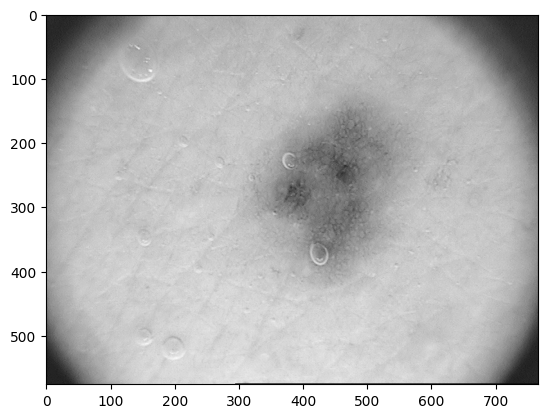

In [19]:
print(images[1].shape)
plt.imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2GRAY), cmap = "gray")

## Helper Functions

In [56]:
def conditional_reconstruction(im, marker, b, num_iter = 10):
    for i in range(num_iter):
        temp = cv2.dilate(marker, b)
        marker = cv2.bitwise_and(im.astype(np.uint8), temp.astype(np.uint8))
    return marker

Discrete Disk:


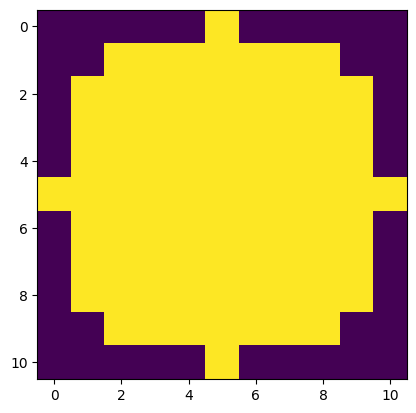

In [33]:
def generate_discrete_disk(radius):
    diameter = 2 * radius + 1 
    center = radius 

    # Generate a grid of coordinates
    x, y = np.meshgrid(np.arange(diameter), np.arange(diameter))

    # Calculate the distance from each point to the center
    distances = np.sqrt((x - center)**2 + (y - center)**2)

    # Create a mask for the disk
    disk_mask = (distances <= radius).astype(np.uint8)

    return disk_mask
    
# Generate the discrete disk
disk = generate_discrete_disk(5)
big_disk = generate_discrete_disk(10)
print("Discrete Disk:")
plt.imshow(disk)


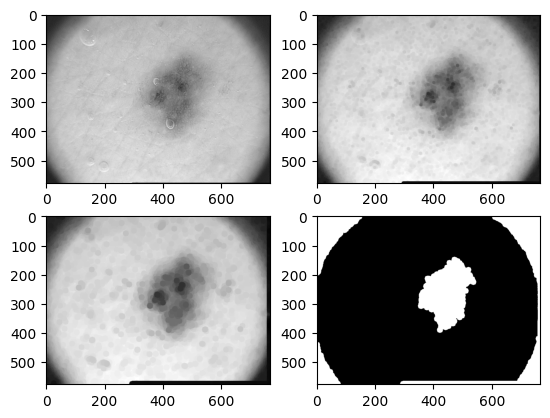

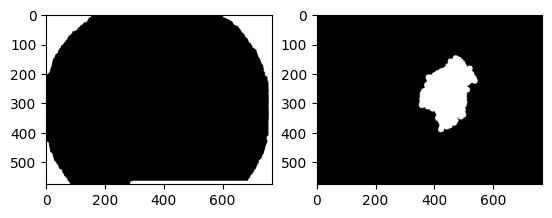

In [85]:
im = cv2.cvtColor(images[1], cv2.COLOR_BGR2GRAY)
plt.figure()
plt.subplot(221)
plt.imshow(im, cmap = "gray")
plt.subplot(222)
im = cv2.erode(im, disk)
plt.imshow(im, cmap = "gray")

plt.subplot(223)
im = cv2.erode(im, disk)
plt.imshow(im, cmap = "gray")

plt.subplot(224)
_, im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
plt.imshow(im, cmap = "gray")

# Perform conditional reconstruction using the edge as a marker to get rid of ring edge artifact
edge_marker = np.zeros(im.shape)
edge_marker[0, :] = 1
edge_marker[-1, :] = 1
edge_marker[:, 0] = 1
edge_marker[:,-1] = 1
recon = conditional_reconstruction(im, edge_marker, big_disk)
plt.figure()
plt.subplot(121)
plt.imshow(recon, cmap = "gray")
plt.subplot(122)
plt.imshow(im == cv2.bitwise_not(recon.astype(np.uint8)), cmap = "gray")